In [33]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [34]:
ct_dir = "/Users/alex/Desktop/NeuroRex/data/modality_classifier/CT"
mri_dir = "/Users/alex/Desktop/NeuroRex/data/modality_classifier/MRI"

In [35]:
def decode_image(image_data, file_path):
    ext = tf.strings.lower(tf.strings.split(file_path, '.')[-1])
    
    def decode_jpg():
        return tf.image.decode_jpeg(image_data, channels=3)
    
    def decode_png():
        return tf.image.decode_png(image_data, channels=3)
    
    return tf.case([
        (tf.equal(ext, 'jpg'), decode_jpg),
        (tf.equal(ext, 'jpeg'), decode_jpg),
        (tf.equal(ext, 'png'), decode_png),
    ], default=decode_jpg, exclusive=True)

In [36]:
IMG_SIZE = (224, 224)

def preprocess_path(filepath, label):
    image_data = tf.io.read_file(filepath)
    image = decode_image(image_data, filepath)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/255.0
    return image, label

In [37]:
ct_files = [os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
mri_files = [os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]

In [39]:
all_files = ct_files+mri_files
all_labels = [0]*len(ct_files) + [1]*len(mri_files)

In [48]:
from sklearn.model_selection import train_test_split

train_files, temp_files, train_labels, temp_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

In [49]:
def make_dataset(files, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000, seed=42)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [50]:
train_ds = make_dataset(train_files, train_labels)
val_ds = make_dataset(val_files, val_labels, shuffle=False)
test_ds = make_dataset(test_files, test_labels, shuffle=False)

In [52]:
from models.modality_classifier.cnn_model import modality_classifier

model = modality_classifier()
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


2025-04-23 17:44:37.773893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


241/241 [==============================] - 41s 152ms/step - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.0230 - val_accuracy: 0.9948
Epoch 2/5
241/241 [==============================] - 35s 144ms/step - loss: 0.0127 - accuracy: 0.9969 - val_loss: 0.0128 - val_accuracy: 0.9979
Epoch 3/5
241/241 [==============================] - 36s 145ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.0184 - val_accuracy: 0.9969
Epoch 4/5
241/241 [==============================] - 37s 150ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.0142 - val_accuracy: 0.9990
Epoch 5/5
241/241 [==============================] - 37s 151ms/step - loss: 0.0081 - accuracy: 0.9966 - val_loss: 0.0230 - val_accuracy: 0.9969


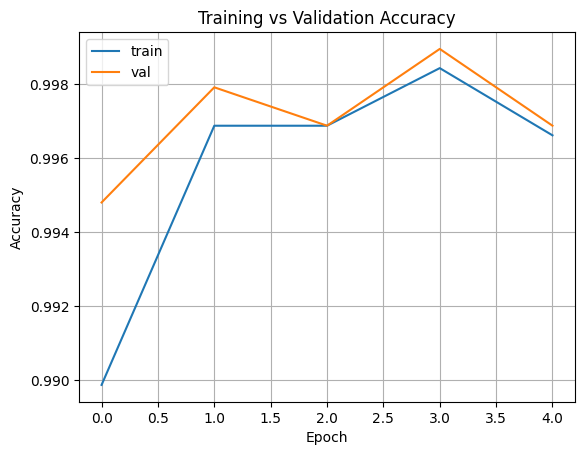

In [54]:
plt.plot(history.history['accuracy'], label ='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
model.save('models/modality_classifier/mobilenetv2_modality.h5')
model.save('models/modality_classifier/mobilenetv2_modality.keras')

In [57]:
model.evaluate(test_ds)

31/31 [==============================] - 4s 126ms/step - loss: 0.0172 - accuracy: 0.9979


[0.017162678763270378, 0.9979209899902344]

1/1 [==============================] - 1s 1s/step


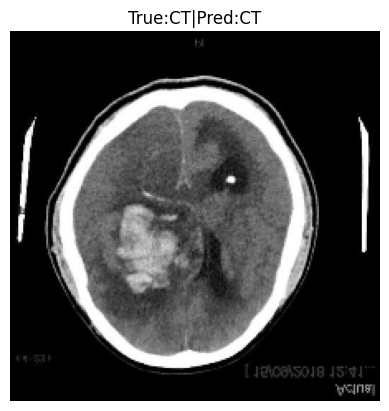

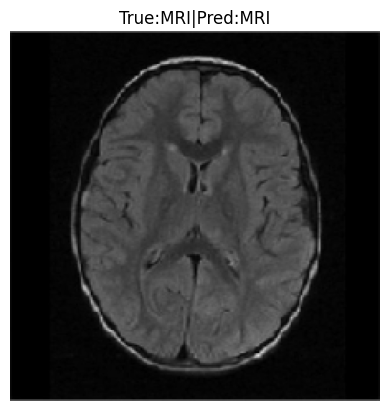

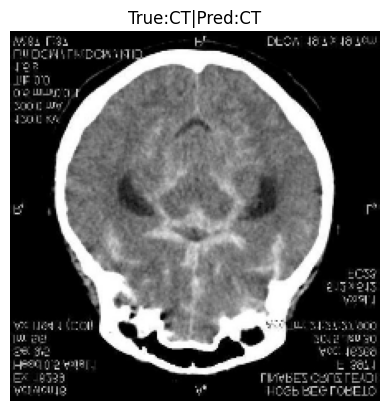

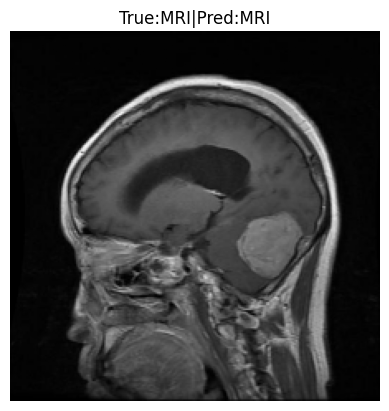

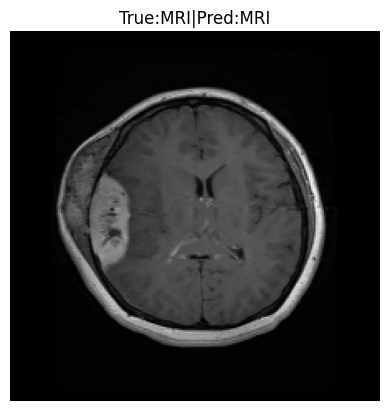

In [60]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    
    for i in range(5):
        plt.imshow(images[i])
        plt.title(f"True:{'MRI' if labels[i] else 'CT'}|Pred:{'MRI' if preds[i] else 'CT'}")
        plt.axis('off')
        plt.show()